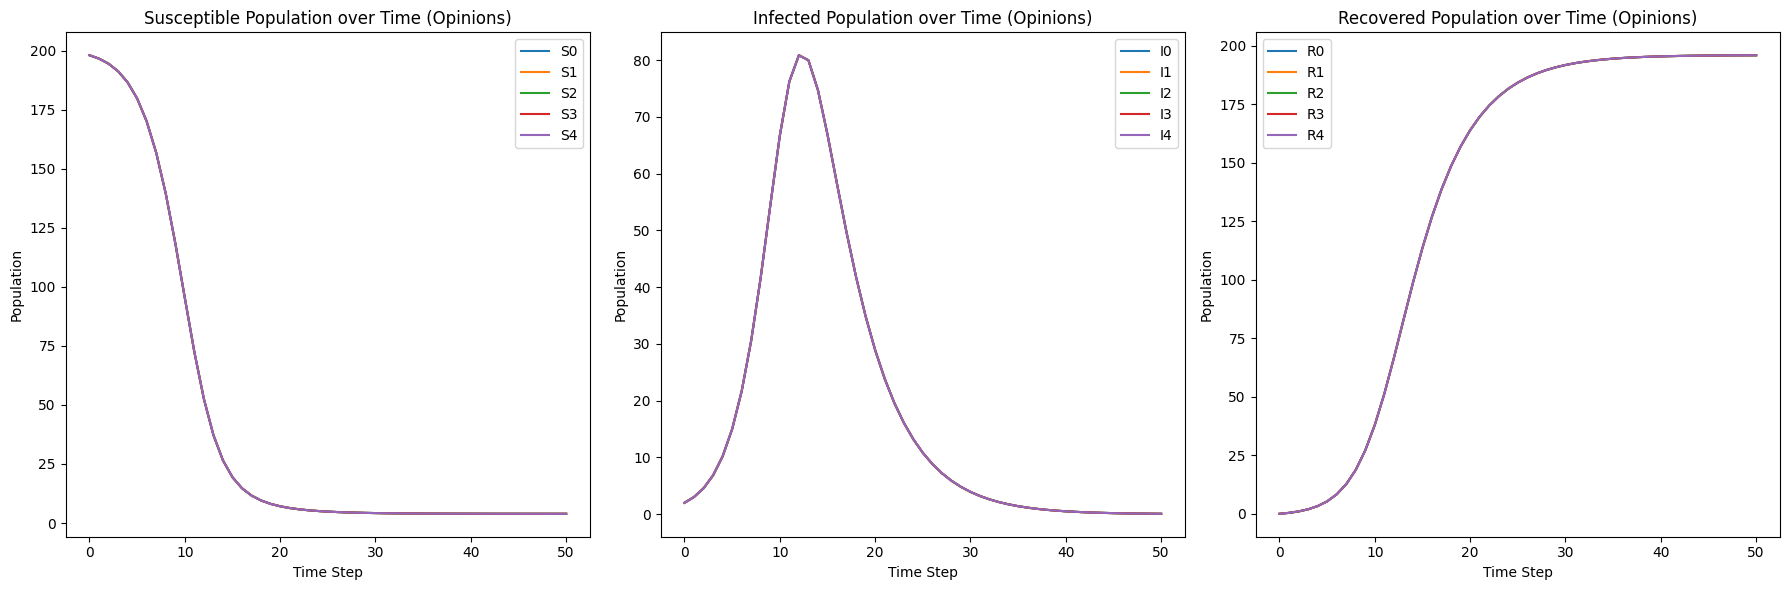

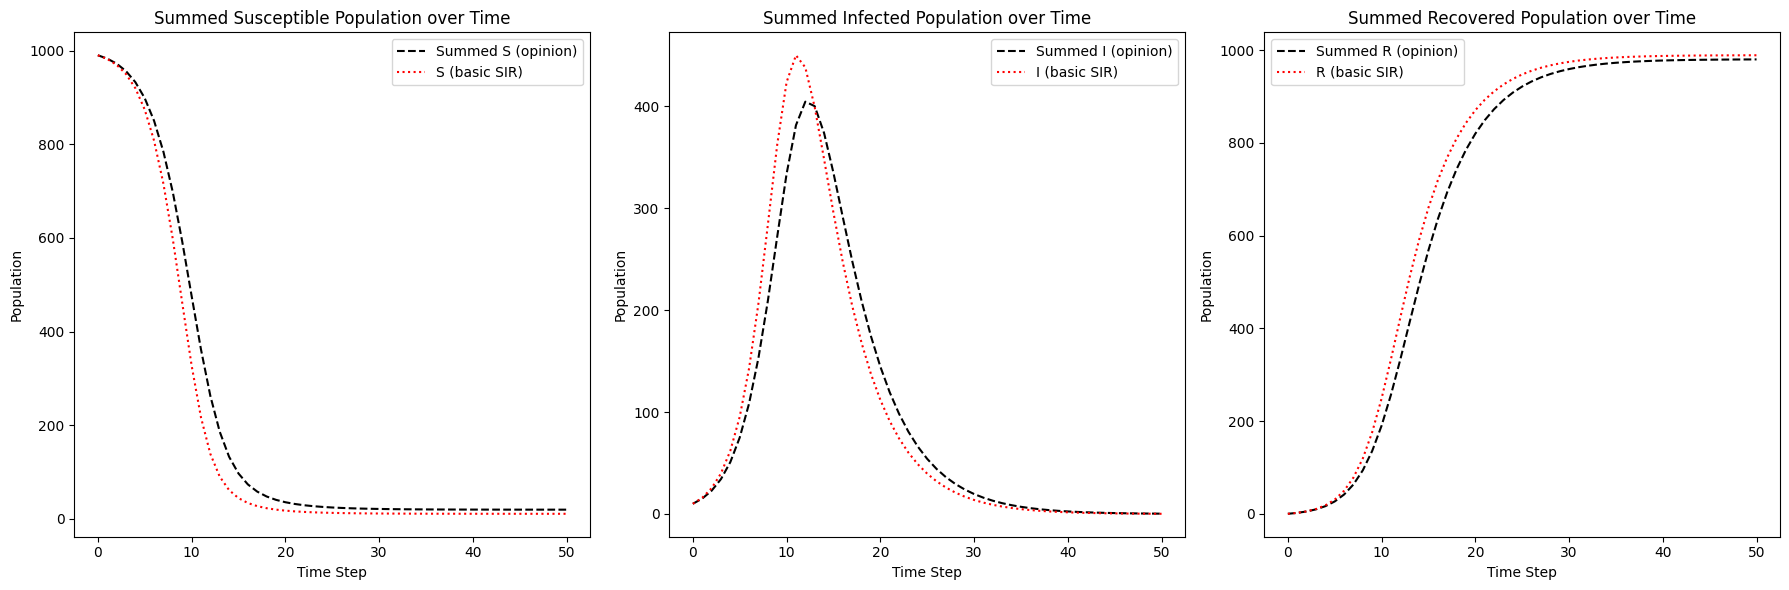

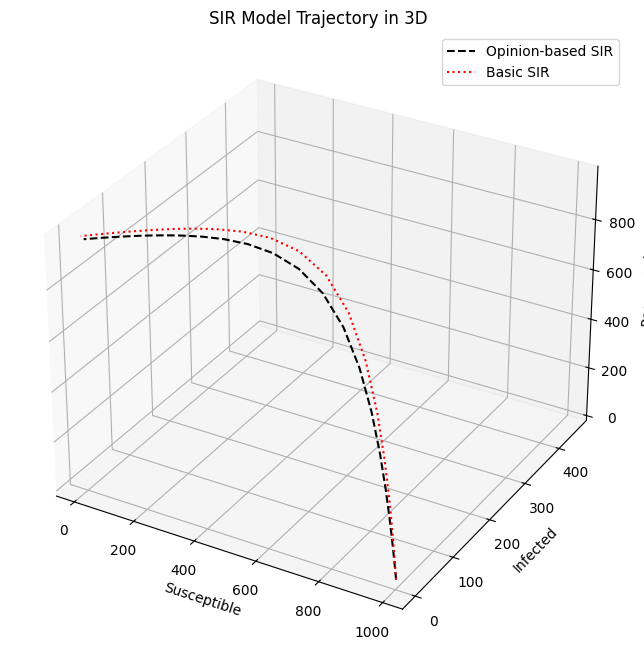

In [68]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from mpl_toolkits.mplot3d import Axes3D

def pii(q):
    return 1 / (1 + np.exp(q)), np.exp(q) / (1 + np.exp(q))

def transition_matrix(beta, gamma, statevector, q):
    n = len(q)
    matrix_size = 3 * n
    matrix = np.zeros((matrix_size, matrix_size))

    N = np.sum(statevector)
    ps = statevector[:n] / N
    pi = statevector[n:2*n] / N
    pr = statevector[2*n:3*n] / N

    pii1_vals, pii2_vals = pii(q)

    # Fill the matrix according to the pattern
    for i in range(n):
        for j in range(n):
            # S_i -> S_j
            matrix[i, j] = ps[j] + pi[j] * (pii1_vals[i] * (1-beta) + pii2_vals[i]) + pr[j]
            # S_i -> I_j
            matrix[i, n+j] = pi[j] * pii1_vals[i] * beta
        
        for j in range(n):
            # I_i -> I_j
            matrix[n+i, n+j] = (1-gamma) * (ps[j] + pi[j] + pr[j])
            # I_i -> R_j
            matrix[n+i, 2*n+j] = gamma * (ps[j] + pi[j] + pr[j])
        
        for j in range(n):
            # R_i -> R_j
            matrix[2*n+i, 2*n+j] = ps[j] + pi[j] + pr[j]
    
    return matrix

def simulate_transition(population, beta, gamma, steps, q):
    populations = [np.array(population)]
    for _ in range(steps):
        matrix = transition_matrix(beta, gamma, populations[-1], q)
        population = populations[-1] @ matrix
        populations.append(population)
    return populations

def simulate_basic_SIR(init_state, beta, gamma, steps):
    S, I, R = init_state
    populations = [(S, I, R)]
    N = S + I + R
    
    for _ in range(steps):
        new_S = S - beta * S * I / N
        new_I = I + beta * S * I / N - gamma * I
        new_R = R + gamma * I
        
        S, I, R = new_S, new_I, new_R
        populations.append((S, I, R))
    
    return populations

def plot_results(populations, basic_SIR_populations, n):
    timesteps = len(populations)
    time = np.arange(timesteps)

    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    # Sum populations for opinion-based model
    S_total = [sum(pop[:n]) for pop in populations]
    I_total = [sum(pop[n:2*n]) for pop in populations]
    R_total = [sum(pop[2*n:3*n]) for pop in populations]

    axs[0].plot(time, S_total, label='Summed S (opinion)', linestyle='--', color='black')
    axs[1].plot(time, I_total, label='Summed I (opinion)', linestyle='--', color='black')
    axs[2].plot(time, R_total, label='Summed R (opinion)', linestyle='--', color='black')

    # Plot basic SIR model
    basic_S, basic_I, basic_R = zip(*basic_SIR_populations)
    axs[0].plot(time, basic_S, label='S (basic SIR)', linestyle=':', color='red')
    axs[1].plot(time, basic_I, label='I (basic SIR)', linestyle=':', color='red')
    axs[2].plot(time, basic_R, label='R (basic SIR)', linestyle=':', color='red')

    for ax in axs:
        ax.set_xlabel('Time Step')
        ax.set_ylabel('Population')
        ax.legend()

    axs[0].set_title('Summed Susceptible Population over Time')
    axs[1].set_title('Summed Infected Population over Time')
    axs[2].set_title('Summed Recovered Population over Time')

    plt.tight_layout()
    plt.show()

def plot_opinion_results(populations, n):
    timesteps = len(populations)
    time = np.arange(timesteps)

    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    for i in range(n):
        S = [pop[i] for pop in populations]
        I = [pop[n+i] for pop in populations]
        R = [pop[2*n+i] for pop in populations]

        axs[0].plot(time, S, label=f'S{i}')
        axs[1].plot(time, I, label=f'I{i}')
        axs[2].plot(time, R, label=f'R{i}')

    for ax in axs:
        ax.set_xlabel('Time Step')
        ax.set_ylabel('Population')
        ax.legend()

    axs[0].set_title('Susceptible Population over Time (Opinions)')
    axs[1].set_title('Infected Population over Time (Opinions)')
    axs[2].set_title('Recovered Population over Time (Opinions)')

    plt.tight_layout()
    plt.show()


n = 5  # Number of opinions

N = 1000
int_I = 0.01 * N
int_R = 0
int_S = N - int_I - int_R

init_state = (int_S, int_I, int_R)

init_opinion_state = np.array([int_S // n] * n + [int_I // n] * n + [int_R // n] * n)

q = np.array([-10 * i for i in range(n)])
beta = 0.8  #  infection rate
gamma = 0.2  #  recovery rate
steps = 50  # Number of time steps to simulate

populations = simulate_transition(init_opinion_state, beta, gamma, steps, q)
basic_SIR_populations = simulate_basic_SIR(init_state, beta, gamma, steps)

plot_opinion_results(populations, n)
plot_results(populations, basic_SIR_populations, n)


def plot_3d_results(populations, basic_SIR_populations):
    # Extract populations for opinion-based model
    n = len(populations[0]) // 3
    S_opinion = np.array([sum(pop[:n]) for pop in populations])
    I_opinion = np.array([sum(pop[n:2*n]) for pop in populations])
    R_opinion = np.array([sum(pop[2*n:3*n]) for pop in populations])

    # Extract populations for basic SIR model
    S_basic = np.array([pop[0] for pop in basic_SIR_populations])
    I_basic = np.array([pop[1] for pop in basic_SIR_populations])
    R_basic = np.array([pop[2] for pop in basic_SIR_populations])

    # Plotting the 3D trajectory
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    ax.plot(S_opinion, I_opinion, R_opinion, label='Opinion-based SIR', linestyle='--', color='black')
    ax.plot(S_basic, I_basic, R_basic, label='Basic SIR', linestyle=':', color='red')

    ax.set_xlabel('Susceptible')
    ax.set_ylabel('Infected')
    ax.set_zlabel('Recovered')
    ax.set_title('SIR Model Trajectory in 3D')
    ax.legend()

    plt.show()

    
plot_3d_results(populations, basic_SIR_populations)





